# Computationally rational gaze-based interaction

Andrew Howes & Xiuli Chen

The purpose of this tutorial is to introduce an approach to building computationally rational models.

It does the following:

* imports libraries,
* defines a cognitive POMDP for computational rationality,
* defines a theory of gaze based interaction as a cognitive POMDP,
* defines auxiliary assumptions (the task),
* combines the theory and auxiliary assumptions into a machine learning problem (a model) that can be solved with baselines3,
* train the model,
* examines the learning curve to ensure that we are generating an approximately optimal policy,
* animates the model behaviour to develop our intuitions about its adaptation,
* compares the model to human data.

Preqrequisites:

* foveated vision notebook
* Bayesian integration notebook
* POMDP notebook
* Q-learning notebook
* PPO notebook


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sys

import gym
from gym import spaces

import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')

In [2]:
from google.colab import drive
drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# !pip install stable_baselines3

In [4]:
!ls /content/gdrive/MyDrive/ah2122/Projects/CHI2022-Tutorial
sys.path.append('/content/gdrive/My Drive/ah2122/Projects/CHI2022-Tutorial')

from gazetools import *

behaviour_trace.csv  internal_POMDP.png  policy.zip   time_v_target_size.png
gazetools.py	     monitor.csv	 __pycache__


### A Cognitive POMDP

A cognitive POMDP is a framework for specifying 'cognitive problems'. Cognitive problems are theories of the problems faced by cognition.

If we assume that people are computationally rational then the optimal solution to a cognitive problem predicts human behavior.

We can write a program that formalises the cognitive problem.

In [5]:
class CognitiveTheory():

    def __init__(self):
        self.internal_state = {}
        
    def step(self, aux, decision):
        ''' Define the cognitive POMDP.'''
        self._update_state_with_decision(decision)
        action = self._get_action()
        external_state, done = aux.external_env(action)
        percept, percept_std = self._get_percept(aux.external_state)
        self._update_state_with_percept(percept, percept_std)
        obs = self._get_obs()
        reward = self._get_reward()
        return obs, reward, done

### A theory of gaze-based interaction

Each of the entities in CognitiveTheory must be defined so as to state our theory of gaze-based interaction. The theory makes the following assumptions:

* Target location percepts in human vision are corrupted by Gaussian noise.
* The standard deviation of noise increases linearly with eccentricity from the fovea.
* Sequences of noisy percepts are optimally integrated.
* Intended eye movements (oculomotor decisions) are corrupted by signal dependent Gaussian noise.

These assumptions are further described in Chen et al. (2021).

In [6]:
class GazeTheory(CognitiveTheory):

    def __init__(self):
        ''' Initialise the theoretically motivated parameters.'''
        # weight eye movement noise with distance of saccade
        self.oculamotor_noise_weight = 0.01
        # weight noise with eccentricity
        self.perceptual_noise_weight = 0.09
        # step_cost for the reward function
        self.step_cost = -1
        # super.__init__()

    def reset_internal_env(self, external_state):
        ''' The internal state includes the fixation location, the latest estimate of 
        the target location and the target uncertainty. Assumes that there is no 
        uncertainty in the fixation location.
        Assumes that width is known. All numbers are on scale -1 to 1.
        The target_std represents the strength of the prior.'''
        self.internal_state = {'fixation': np.array([-1,-1]),  
                               'target': np.array([0,0]), 
                               'target_std': 0.1,# this should be set to the true target_std as defined in GazeTask.
                               'width': external_state['width'],
                               'decision': np.array([-1,-1])} 
        return self._get_obs()

    def _update_state_with_decision(self, decision):
        self.internal_state['decision'] = decision
        
    def _get_action(self):
        ''' Take a decision and add noise.'''
        # !!!! should take internal_state as parameter
        move_distance = get_distance( self.internal_state['fixation'], 
                                     self.internal_state['decision'] )
        
        ocularmotor_noise = np.random.normal(0, self.oculamotor_noise_weight * move_distance, 
                                        self.internal_state['decision'].shape)
        # action is decision plus noise
        action = self.internal_state['decision'] + ocularmotor_noise
        
        # make an adjustment if action is out of range. 
        # This should be done somewhere other than in the theory.
        action = np.clip(action,-1,1)
        return action
    
    def _get_percept(self, external_state):
        ''' define a psychologically plausible percept function in which acuity 
        falls off with eccentricity.''' 
        eccentricity = get_distance( external_state['target'], external_state['fixation'] )
        prcpt_std = self.perceptual_noise_weight * eccentricity
        perceptual_noise = np.random.normal(0, prcpt_std, 
                                         external_state['target'].shape)
        prcpt = external_state['target'] + perceptual_noise
        return prcpt, prcpt_std

    
    def _update_state_with_percept(self, percept, percept_std):
        posterior, posterior_std = self.bayes_update(percept, 
                                                     percept_std, 
                                                     self.internal_state['target'],
                                                     self.internal_state['target_std'])
        self.internal_state['target'] = posterior
        self.internal_state['target_std'] = posterior_std

    def bayes_update(self, percept, percept_std, belief, belief_std):
        ''' A Bayes optimal obs function that integrates multiple percepts.
        The belief is the prior.'''
        z1, sigma1 = percept, percept_std
        z2, sigma2 = belief, belief_std
        w1 = sigma2**2 / (sigma1**2 + sigma2**2)
        w2 = sigma1**2 / (sigma1**2 + sigma2**2)
        posterior = w1*z1 + w2*z2
        posterior_std = np.sqrt( (sigma1**2 * sigma2**2)/(sigma1**2 + sigma2**2) )
        return posterior, posterior_std
    
    def _get_obs(self):
        # the Bayesian posterior has already been calculated so just return it.
        # could also return the target_std so that the controller knows the uncertainty 
        # of the observation.
        #return self.internal_state['target']
        return np.array([self.internal_state['target'][0],
                        self.internal_state['target'][1],
                        self.internal_state['target_std']])
    
    def _get_reward(self):
        distance = get_distance(self.internal_state['fixation'], 
                                self.internal_state['target'])
        
        if distance < self.internal_state['width'] / 2:
            reward = 0
        else:
            reward = -distance # a much better model of the psychological reward function is possible.
            
        return reward


### Auxiliary assumptions

In order to test the theory we need to make auxiliary assumptions. For the theory of gaze-based interaction presented here, the auxiliary assumptions mostly concern the task as defined in the external_environment. Auxiliary assumptions allow us to make predictions from the theory for a particular task. The theory makes predictions for many more tasks. For example, adaptation to mixed target widths and distances.

Note auxiliary assumptions must not be "auxiliary hypothesis". See Gershman (2019) https://link.springer.com/article/10.3758/s13423-018-1488-8

In [7]:
class GazeTask():
    
    def __init__(self):
        self.target_width = 0.15
        self.target_loc_std = 0.3

    def reset_external_env(self):
        ''' The external_state includes the fixation and target location.
        Choose a new target location and reset to the first fixation location.'''
        
        def _get_new_target():
            x_target =np.clip(np.random.normal(0, self.target_loc_std),-1,1)
            y_target =np.clip(np.random.normal(0, self.target_loc_std),-1,1)         
            return np.array( [x_target, y_target] )
    
        fx = np.array([-1,-1])
        tg = _get_new_target()
        self.external_state = {'fixation':fx, 'target':tg, 'width':self.target_width }
    
    def external_env(self, action):
        self.external_state['fixation'] = action
        
        # determine when the goal has been achieved.
        distance = get_distance(self.external_state['fixation'], 
                                self.external_state['target'])
        if distance < self.external_state['width']/2 :
            done = True
        else:
            done = False
        
        return self.external_state, done
    

### Gym environment

In order to find an optimal policy we use the theory and auxiliary assumptions to define a machine learning problem, here, making use of the framework defined by one specific library called gym.

For further information see: https://gym.openai.com/

gym.Env is a class provided by this library. Note that Env here refers to all of the components of the, including both internal and external environment, with the exception of the controller.

In [8]:
class GazeModel(gym.Env): # also inherit from Alex's BaseModel in Corati.
    
    def __init__(self):
        
        def default_box(x):
            return spaces.Box(low=-1, high=1, shape=(x, ), dtype=np.float64)
        
        self.GT = GazeTheory()
        self.TX = GazeTask()        
        
        # Required by gym. These define the range of each variable.
        # note that in gym an 'action' is a 'decision' in our framework.
        # Each action has an x,y coordinate therefore the box size is 2.
        # Each obs has a an x,y and an uncertainty therefore the box size is 3.
        self.action_space = default_box(2)
        self.observation_space = default_box(3)
        
        # max_fixations per episode. Used to curtail exploration early in training.
        self.max_steps = 500
        
    def reset(self):
        self.n_step = 0
        self.TX.reset_external_env()
        obs = self.GT.reset_internal_env( self.TX.external_state )
        return obs
    
    def step(self, decision):
        obs, reward, done = self.GT.step( self.TX, decision )
        self.n_step+=1

        # give up if been looking for too long
        if self.n_step > self.max_steps:
            done = True
        
        info = self.get_info()
        return obs, reward, done, info
    
    def get_info(self):
        return {'step': self.n_step,
                'target_width': self.TX.target_width,
                'target_x': self.TX.external_state['target'][0],
                'target_y': self.TX.external_state['target'][1],
                'fixate_x':self.TX.external_state['fixation'][0],
                'fixate_y':self.TX.external_state['fixation'][1] }

### Test the model

Step through the untrained model to check for simple bugs. More comprehensive tests needed.

In [9]:
model = GazeModel()

model.reset()

i=0
done = False
while not done:
    # make a step with a randomly sampled action
    obs, reward, done, info = model.step(model.action_space.sample())
    i+=1

print(i)

36


### Train the model

We can train the model to generate a controller.

By plotting the learning curve we can see whether the performance improves with training and whether the model approaches an optimum performance. We are interested in approximately optimal performance, so if the training curve is not approaching asymptote then we need to train with more timesteps or revise the model.

We can see that at first the model uses hundreds of fixations to find the target, this is because it has not yet learned to move the gaze in a way that is informed by the observation. As it learns to do this, it takes fewer steps to gaze at the target and its performance improves.

If our problem definition is correct then the model will get more 'human-like' the more that it is trained. In other words, training makes it a better model of interaction.


Done training.


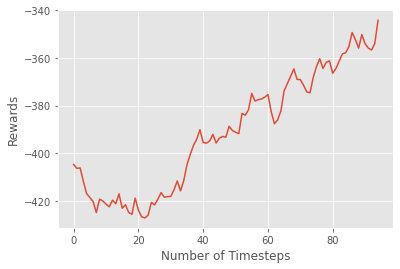

In [10]:
timesteps = 50000
controller = train(model, timesteps)
plot_learning_curve()

### Run the model
Run the trained model and save a trace of each episode to csv file.

In [11]:
run_model( model, controller, 100, 'behaviour_trace.csv' )

'/content/gdrive/My Drive/ah2122/Projects/CHI2022-Tutorial/behaviour_trace.csv'

### Next

Go to notebook 'visualise'

### References
Chen, X., Acharya, A., Oulasvirta, A., & Howes, A. (2021, May). An adaptive model of gaze-based selection. In Proceedings of the 2021 CHI Conference on Human Factors in Computing Systems (pp. 1-11).